### 準備

In [1]:
import torch
from tqdm import tqdm
from stable_baselines3 import PPO

from stable_baselines3.common.callbacks import EvalCallback

In [2]:
import os
import sys
sys.path.append(os.path.pardir)

In [3]:
from cpm_torch.CPM_Image import *
from cpm_torch.CPM import *
from cpm_torch.CPMEnv import *
from cpm_torch.Training.CPM_PPO import *
from cpm_torch.Training.CPM_Policy import *

error: XDG_RUNTIME_DIR not set in the environment.


In [4]:
from datetime import datetime

def create_timestamped_results_dir(base_dir="results/PPOs"):
    """
    Creates a timestamped directory within the base results directory.
    
    Args:
        base_dir (str): Base directory where the timestamped folder will be created
        
    Returns:
        str: Path to the created directory
    """
    # Create the base directory if it doesn't exist
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    
    # Create a timestamp string
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    
    # Create the full path
    result_dir = os.path.join(base_dir, timestamp)
    
    # Create the directory
    os.makedirs(result_dir)
    
    print(f"Created results directory: {result_dir}")
    return result_dir


is_continue = False  # Set to True if you want to continue training from a previous model

if is_continue:
    result_dir = "results/PPOs/20250513-041642"  # Example directory for demonstration
    model_dir = os.path.join(result_dir, "recent_model")
else:
    result_dir = create_timestamped_results_dir()

Created results directory: results/PPOs/20250522-005934


### ハイパーパラメータ

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPUを利用します: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CPUを利用します")

config = CPM_config(
    l_A=1.0,  # 面積エネルギー項の係数λ_A
    l_L=1.0,  # 周囲長エネルギー項の係数λ_L
    A_0=100.0,  # 目標細胞面積 A_0
    L_0=52.0,  # 目標細胞周囲長 L_0
    T=1.0,  # 温度パラメータ T
)
print(config.__dict__)

GPUを利用します: NVIDIA H100 PCIe
{'size': (256, 256), 'dim': 2, 'height': 256, 'width': 256, 'depth': 1, 'l_A': 1.0, 'l_L': 1.0, 'A_0': 100.0, 'L_0': 52.0, 'T': 1.0}


### 環境

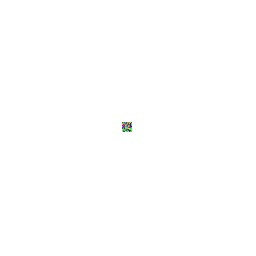

In [6]:
env = CPMEnv(config)  # CPM環境のインスタンスを作成
env.reset()  # 環境をリセット
env.render()  # 環境を描画

In [7]:
eval_freq = 10000
best_model_save_path = os.path.join(result_dir, "best_model")
n_eval_episodes = 10

eval_callback = EvalCallback(
    env,    # 評価環境
    log_path='path/to/log',
    eval_freq=eval_freq,
    deterministic=True,
    render=True,
    best_model_save_path=best_model_save_path,
    n_eval_episodes=n_eval_episodes
)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Number of parameters: 17548759
log_std: torch.Size([29584])
policy_net.0.weight: torch.Size([128, 9])
policy_net.0.bias: torch.Size([128])
policy_net.2.weight: torch.Size([128, 128])
policy_net.2.bias: torch.Size([128])
policy_net.4.weight: torch.Size([4, 128])
policy_net.4.bias: torch.Size([4])
value_net.0.downs.0.double_conv.0.weight: torch.Size([64, 1, 3, 3])
value_net.0.downs.0.double_conv.0.bias: torch.Size([64])
value_net.0.downs.0.double_conv.1.weight: torch.Size([64])
value_net.0.downs.0.double_conv.1.bias: torch.Size([64])
value_net.0.downs.0.double_conv.3.weight: torch.Size([64, 64, 3, 3])
value_net.0.downs.0.double_conv.3.bias: torch.Size([64])
value_net.0.downs.0.double_conv.4.weight: torch.Size([64])
value_net.0.downs.0.double_conv.4.bias: torch.Size([64])
value_net.0.downs.1.double_conv.0.weight: torch.Size([128, 64, 3, 3])
value_net.0.downs.1.double_conv.0.bias: torch.Size([128

/root/.pyenv/versions/3.9.17/lib/python3.9/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

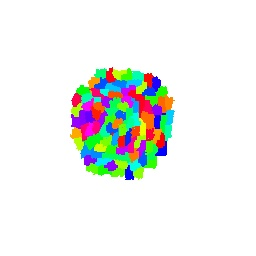

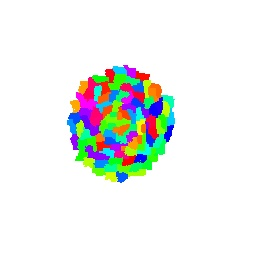

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 7.07e+04 |
| time/              |          |
|    fps             | 3        |
|    iterations      | 1        |
|    time_elapsed    | 652      |
|    total_timesteps | 2048     |
---------------------------------


OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 79.18 GiB of which 299.25 MiB is free. Process 1548247 has 452.00 MiB memory in use. Process 1768164 has 452.00 MiB memory in use. Process 1889489 has 452.00 MiB memory in use. Process 1913035 has 452.00 MiB memory in use. Process 2125623 has 452.00 MiB memory in use. Process 2166779 has 3.86 GiB memory in use. Process 2168963 has 3.86 GiB memory in use. Process 2171167 has 3.94 GiB memory in use. Process 2179985 has 3.94 GiB memory in use. Process 2181188 has 4.15 GiB memory in use. Process 2187796 has 4.15 GiB memory in use. Process 2190338 has 4.15 GiB memory in use. Process 2193304 has 4.15 GiB memory in use. Process 2196088 has 4.15 GiB memory in use. Process 2265541 has 4.15 GiB memory in use. Process 2266378 has 3.86 GiB memory in use. Process 2266783 has 4.15 GiB memory in use. Process 2269742 has 4.03 GiB memory in use. Process 2271722 has 4.03 GiB memory in use. Process 2287053 has 19.98 GiB memory in use. Of the allocated memory 19.36 GiB is allocated by PyTorch, and 25.79 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
model = PPO(CPMPolicy, env, tensorboard_log=os.path.join(result_dir), verbose=1, n_epochs=50, n_steps=1024, batch_size=16)
# パラメータ数を表示
print(f"Number of parameters: {sum(p.numel() for p in model.policy.parameters())}")
for name, param in model.policy.named_parameters():
    print(f"{name}: {param.size()}")
print(model.policy)
model.learn(total_timesteps=1000000, progress_bar=True)  # 学習を実行